# การทำนายทิศทางการหันของใบหน้า โดยใช้ Face Pose Model

ในกระบวนการพัฒนาเครื่องมือการทำนายทิศทางการหันของใบหน้า จะมีขั้นตอนเริ่มต้นจากการกำหนดจุดสำคัญต่าง ๆ บนใบหน้า ซึ่งจากโมเดลที่พัฒนาโดย Mediapipe ทำให้เราสามารถกำหนดตำแหน่งจุดที่สำคัญบนแกนของร่างกายได้จำนวนมากกว่า 400 จุด เพื่อใช้ในการทำนายลักษณะใบหน้า ซึ่งการกำหนดตำแหน่งเหล่านี้ ได้รับการพัฒนามาจากการเรียนรู้ภาพต้นแบบสามมิติ ทำให้ได้จุดและพิกัดบนใบหน้าทั้งหมด 468 พิกัด ซึ่งในตัวอย่างนี้ เราจะเลือกเฉพาะบางพิกัดจำนวน 6 ตำแหน่งที่สำคัญเพื่อใช้ในการหาทิศทางการหันของใบหน้า ดังรูป
<br><br>
![face_landmarks.png](https://raw.github.com/hengkp/mediapipe_examples/main/landmarks/face_landmarks.png)<br><br>

ซึ่งเครื่องมือจากโมเดล Mediapipe ดังกล่าวนี้ สามารถทำนาย ทิศทางการหันของใบหน้าได้เป็น 5 รูปแบบ ได้แก่ หน้าตรง, ก้มหน้า, เงยหน้า, หันซ้าย, หันขวา โดยแต่ละท่าทางที่ทำนายได้ จะมีการประมวลผลข้อมูลจากจุดและพิกัดบนร่างกายจำนวน 6 จุด กล่าวคือ

1. การทำนายทิศทางการหันของใบหน้าแบบ **ก้มหน้า / เงยหน้า** ทำการวัดระยะทางระหว่างริมฝีปากด้านบนกับจุดระหว่างคิ้ว (ตำแหน่งที่ 0 กับ 8) เปรียบเทียบกับระยะทางระหว่างริมฝีปากด้านบนกับปลายจมูก (ตำแหน่งที่ 0 กับ 4) โดยวัดในระนาบเดียวกัน (ใช้วิธี projection ด้วย) ในกรณีที่อัตราส่วนระยะทางของคิ้วกับปาก *มากกว่า* ระยะทางของจมูกกับปาก เกินกว่า 3 เท่า (บวก/ลบ 20เปอร์เซ็น) จะถูกนับว่าก้มหน้าลง

2. การทำนายทิศทางการหันของใบหน้าแบบ **หันซ้าย / หันขวา** ทำการวัดระยะทางระหว่างหางตาฝั่งซ้ายถึงดั้งจมูก (ตำแหน่งที่ 261 กับ 6) เปรียบเทียบกับระยะทางระหว่างหางตาฝั่งขวาถึงดั้งจมูก (ตำแหน่งที่ 31 กับ 6) ในกรณีที่อัตราส่วนระยะทางของหางตาซ้ายถึงจมูก *น้อยกว่า* ระยะทางของหางตาขวาถึงจมูก เกินกว่า 1 เท่า (บวก/ลบ 20เปอร์เซ็น) จะถูกนับว่าหันซ้าย

<br>

ซึ่งขั้นตอนการนำภาพถ่ายมาผ่านโปรแกรมทำนายทิศทางการหันของใบหน้าได้สรุปเอาไว้ 8 ขั้นตอน ดังนี้
<br><br>
![face_workflow.jpg](https://raw.github.com/hengkp/mediapipe_examples/main/workflows/face_workflow.jpg)
<br><br>

โดยมีรายละเอียดพร้อมตัวอย่างโค้ดในขั้นตอนต่าง ๆ คือ<br>
**ขั้นตอนที่ 1** การนำเข้าโมเดลจาก Mediapipe<br>
**ขั้นตอนที่ 2** นำเข้าภาพ<br>
**ขั้นตอนที่ 3** ปรับขนาดของภาพให้สอดคล้องกับข้อกำหนดของโมเดล<br>
**ขั้นตอนที่ 4** ปรับสัดส่วนค่าสี (intensity) ของภาพให้อยู่ในช่วง 0 - 1<br>
**ขั้นตอนที่ 5** ประมวลผลรูปผ่านโมเดลเพื่อทำนายจุดพิกัดสำคัญ<br>
**ขั้นตอนที่ 6** ดึงข้อมูลพิกัดที่สำคัญที่ได้จากผลการประมวล<br>
**ขั้นตอนที่ 7** แสดงผลรูปการทำนายมือ<br>
**ขั้นตอนที่ 8** แสดงผลแขนที่ยกขึ้น<br>


In [ ]:
#@title **ขั้นตอนที่ 1** การนำเข้าโมเดลจาก Mediapipe

import requests
import os
import tensorflow as tf

# ที่อยู่ของโมเดลที่ต้องการนำเข้า
model_url = "https://storage.googleapis.com/mediapipe-assets/face_landmark.tflite"

# ดาวน์โหลดโมเดลมาเก็บไว้ที่เครื่อง
if not os.path.exists("face_model.tflite"):
    response = requests.get(model_url)
    open("face_model.tflite", "wb").write(response.content)

# นำเข้าโมเดล
model = tf.lite.Interpreter(model_path="face_model.tflite")
model.allocate_tensors()

# เก็บข้อมูลข้อกำหนดของโมเดลสำหรับการเตรียมรูปภาพ
input_details = model.get_input_details()
output_details = model.get_output_details()

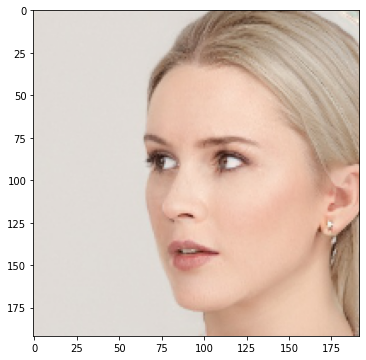

In [ ]:
#@title **ขั้นตอนที่ 2-4** นำเข้าและปรับขนาดของภาพให้สอดคล้องกับข้อกำหนดของโมเดล
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage import io

# ใส่ที่อยู่ของภาพที่ต้องการนำเข้า
image_path = "https://raw.githubusercontent.com/hengkp/mediapipe_examples/main/datasets/faces/face007.jpg"

# ขั้นตอนที่ 2 นำเข้าภาพ
img = io.imread(image_path)

# ขั้นตอนที่ 3 ปรับขนาดภาพให้สอดคล้องกับความต้องการของโมเดล
img = cv2.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][2])) # resize to match inputs of model

# ขั้นตอนที่ 4 ปรับสัดส่วนค่าสี (intensity) ให้อยู่ในช่วง 0 - 1
img = img / 255.0 # normalize image data
img = img.astype(np.float32)

# แสดงตัวอย่างภาพ
fig = plt.figure(figsize=(6, 6)) # define size of figure
plt.imshow(img) # display image in the figure
plt.show()

In [ ]:
#@title **ขั้นตอนที่ 5-6** ประมวลผลรูปผ่านโมเดลเพื่อทำนายจุดพิกัดสำคัญ

# ขั้นตอนที่ 5 ประมวลผลภาพ
model.set_tensor(input_details[0]['index'], [img])
model.invoke()

# ขั้นตอนที่ 6 ดึงข้อมูลพิกัดที่สำคัญที่ได้จากผลการประมวล
keypoints = model.get_tensor(output_details[0]['index'])
keypoints = np.squeeze(keypoints) # remove single-dimensional entries
keypoints = keypoints.reshape(-1, 3)[:, :-1] # reshape to (:, 2) only retrieve 'x' and 'y' axis

In [ ]:
#@title **ขั้นตอนเสริม** ติดตั้ง Library เพิ่มเติมสำหรับการแสดงผล

!pip install --quiet alphashape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 678.6/678.6 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.9 MB/s eta 0:00:00


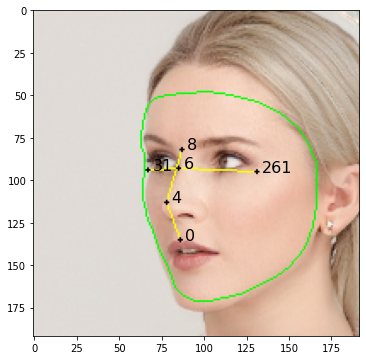

In [ ]:
#@title **ขั้นตอนที่ 7** แสดงผลรูปการทำนายทิศทางการหันของใบหน้า

import alphashape
from matplotlib import pyplot as plt

# เตรียมรูปภาพเพื่อแสดงผล
if np.max(img) <= 1:
    img = (img * 255).astype(np.uint8) # convert image back to [0..255] format
fig, ax = plt.subplots(figsize=(6, 6)) # define size of figure

# วาดเส้นเชื่อมระหว่างพิกัด
keypoints_pairs = [(0, 4), (4, 8), (6, 31), (6, 261)]
for pair in keypoints_pairs: # loop each key pair to draw line
    x1, y1 = int(keypoints[pair[0],0]), int(keypoints[pair[0],1])
    x2, y2 = int(keypoints[pair[1],0]), int(keypoints[pair[1],1])
    cv2.line(img, (x1, y1), (x2, y2), (255, 255, 0), 1) # draw a line

# วาดจุดพิกัดลงในภาพ
for i in [0,4,8,6,31,261]:
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    cv2.circle(img, kp, 1, (0, 0, 0), -1)

# วาดกรอบใบหน้า
def find_contours(keypoints, alpha=0.1):
    shape = alphashape.alphashape(keypoints, alpha).exterior.coords.xy
    contours = np.column_stack(shape)
    return contours
keypoints_contours = find_contours(keypoints)
cv2.drawContours(img, [keypoints_contours.astype(np.int32)], 0, (0, 255, 0), 1)

# ใส่หมายเลขบอกพิกัด
for i in [0,4,8,6,31,261]:
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    ax.annotate(i, kp, fontsize=16, xytext=(5,0), textcoords='offset points') # write text of keypoint ID

# แสดงผลรูปภาพพร้อมพิกัด
plt.imshow(img)
plt.show()

In [ ]:
#@title **ขั้นตอนที่ 8** แสดงผลทิศทางการหันของใบหน้า

def calculate_projected_distance(a, b, c):
    ab = b - a
    ac = c - a
    projection = np.dot(ac, ab) / np.dot(ab, ab) * ab + a
    distance = np.linalg.norm(a - projection)
    return distance

# กำหนดตำแหน่งปาก จมูก คิ้ว
# วัดระยะระหว่าง ปากถึงจมูก และ ปากถึงคิ้ว
# คำนวณสัดส่วนของจมูกกับคิ้ว สำหรับมุมก้มเงย
mouth = 0
nose = 4
eyebrows = 8
up_distance = np.linalg.norm(keypoints[eyebrows] - keypoints[mouth])
down_distance = calculate_projected_distance(keypoints[mouth], keypoints[eyebrows], keypoints[nose])
ud_ratio = up_distance / down_distance

# กำหนดตำแหน่งดั้ง (กลางตามทั้งสองข้าง) ตาซ้าย ตาขวา
# วัดระยะระหว่าง ดั้งถึงตาซ้าย และ ดั้งถึงตาขวา
# คำนวณสัดส่วนของตาซ้ายกับตาขวา สำหรับหันซ้ายขวา
eyes = 6
eye_left = 261
eye_right = 31
left_distance = np.linalg.norm(keypoints[eye_left] - keypoints[eyes])
right_distance = np.linalg.norm(keypoints[eye_right] - keypoints[eyes])
lr_ratio = left_distance / right_distance

# เขียนเงื่อนไขสำหรับทิศทางต่างๆ โดย
# ก้ม  / เงย วัดจาก ค่าสัดส่วนเป็น 3 เท่า ที่มีค่า +/- 20 เปอร์เซ็น (อยู่ระหว่าง 2.4 ถึง 3.6 เท่า)
# ซ้าย / ขวา วัดจาก ค่าสัดส่วนเป็น 1 เท่า ที่มีค่า +/- 20 เปอร์เซ็น (อยู่ระหว่าง 0.8 ถึง 1.2 เท่า)
ud_criteria = np.multiply(1 + np.multiply([-1,1],0.2),3)
lr_criteria = np.multiply(1 + np.multiply([-1,1],0.2),1)
ud_text = "Up" if ud_ratio < ud_criteria[0] else "Down" if ud_ratio > ud_criteria[1] else "Straight"
lr_text = "Left" if lr_ratio < lr_criteria[0] else "Right" if lr_ratio > lr_criteria[1] else "Straight"

# สรุปผลทิศทางการหันของใบหน้า
if (ud_text == "Straight") and (lr_text == "Straight"):
  text = "Straight"
else:
  text =  ud_text + "-" + lr_text

# แสดงผลทิศทางการหันของใบหน้า
print("Direction of Face:", text)

Direction of Face: Straight-Right
